In [2]:
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from htmresearch.support.cans.utils import *
from htmresearch.support.cans.basic_dynamics import *
%load_ext autoreload
%autoreload 2


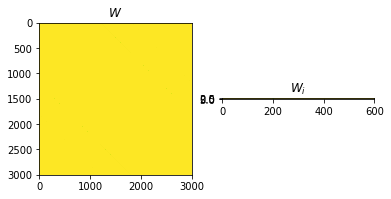

In [17]:

# Set up the shape 
# of the cortical sheet
# xy_ratio = 500

nx = 5
# ny = nx*int(xy_ratio)
ny = 600
n  = nx*ny



rx  = 5
ry  = 600


# Positions of neurons on cortical sheet
X = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
X[:,0] *= rx
X[:,1] *= ry

# Distance matrix of neurons
D = np.zeros((n, n))
for i in range(n):
    for j in range(n):
            D[i,j] = np.linalg.norm( X[i] - X[j])

# Function encoding the connection strength 
# based on distance
J = mexican_hat

# Create a weight matrix given J and D
# basiclally J(D) with some normalization...
W = create_W(J, D)


# Visualize
fig, ax = plt.subplots(1,2)
ax[0].imshow(W)
ax[0].set_title("$W$")
i = 200
ax[1].imshow(W[i].reshape((nx,ny)))
ax[1].set_title("$W_{i}$")
plt.show()

# plt.plot(W[200])
# plt.show()



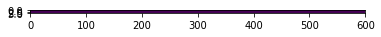

In [18]:
# Creating a mask 
# encoding "topological defects"

mask = np.ones((nx,ny))


# # # num_areas = 6
# R = np.array([

#     [15,60],
#     [15,120]
# ])/np.array([[float(nx), float(ny)]])
# R[:,0] *= rx
# R[:,1] *= ry
# print R.shape

# mask = mask.reshape(-1)
# for i in range(n):
#     dist_to_pins = np.amin( np.linalg.norm(R - X[i].reshape((1,2)), axis=1)) 
#     if dist_to_pins < 3:
#         mask[i] = 0.

plt.imshow(mask.reshape((nx,ny)))
mask = mask.reshape(-1)


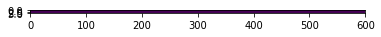

In [19]:
beta_mask = np.ones((nx,ny))*2.
# beta_mask = beta_mask*np.linspace(1.,3.,num=ny).reshape((1,ny))


# beta_mask[:,:ny//2] = 2.
# beta_mask[:,ny//2:] = 3.
# mask[10:20,50:60]    = 0.
# # mask[10:20,115:125]  = 0.


# R = np.indices((nx,ny)).reshape((2,-1)).T/np.array([[float(nx), float(ny)]])
# R[:,0] *= rx
# R[:,1] *= ry

# R = R[np.random.choice(n,size=5, replace=False)]

# rnd = np.random.sample(5)

# beta_mask = np.zeros(n)
# for i in range(n):
#     j = np.argmin( np.linalg.norm(R - X[i], axis=1))
#     beta_mask[i] = 2.5 + (rnd[j] - 0.5)*1.

    
plt.imshow(beta_mask.reshape((nx,ny)))
plt.show()
beta_mask = beta_mask.reshape(-1)


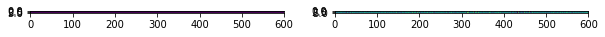

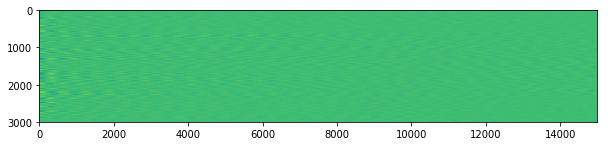

In [20]:
from htmresearch.support.gridcells.utils import cross_correlate
from scipy import ndimage
import numpy.fft as fft
from scipy.special import expit




T = 15000
# X = np.linspace(0.2,0.4,num=T)

S = np.zeros((T,n))




S[0] = np.zeros(n)
# S[0] = np.random.sample(n)*0.001


Beta = np.ones((T,n))*0.0




for t in range(1,T):
    
    s = S[t-1]
    b = np.zeros(n)
    
    tonic = 0.01
    beta  = Beta[t-1]
    
    s_ = evolve_step(W, b  + tonic, s, beta_mask*beta, mask=mask) 
#     s_ = evolve_step(W, b  + tonic, s) 
    S[t]    = s_

    alpha = 0.01
    Beta[t] = (1. - alpha)*Beta[t-1] - alpha*(s_ - np.mean(s_))


fig, ax = plt.subplots(1, 2, figsize=(10, 5));
ax[0].imshow(S[0].reshape((nx,ny)), label="$s_0$")
ax[1].imshow(S[-1].reshape((nx,ny)), label="$s_1$")
plt.show()


plt.figure(figsize=(10,5))
plt.imshow(S.T)
plt.show()





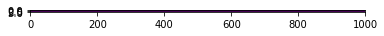

In [12]:

pixel_mask = np.ones((nx,ny))

# for i in range(0,nx, 3):
#     for j in range(0,ny, 3):
#         pixel_mask[i,j] = 1.
        
        
plt.imshow(pixel_mask)



In [13]:

    
S_, V, C = get_data_flow_and_color_maps(S[-6000:], nx,ny, pixel_mask=pixel_mask, t_step=10)




IndexError: too many indices for array

done


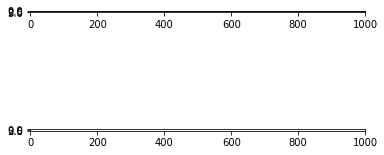

In [14]:
import matplotlib.animation as animation
V_=V

def update(num, data, a):
    S_, C, V_ = data
    a[0].set_data(S_[num].reshape((nx, ny)))
    a[1].set_data(C[num].reshape((nx, ny, 3)))
    

    return a[0],a[1]




fig, ax   = plt.subplots(2,1)

a0  = ax[0].imshow(S_[0].reshape((nx,ny)), animated=True, vmin=np.amin(S_), vmax=np.amax(S_))
a1  = ax[1].imshow(C[0].reshape((nx,ny,3)), animated=True)


ani = animation.FuncAnimation(fig, update, len(S_), fargs=((S_,C, V_), (a0,a1)),
                                   interval=10, blit=True)

ani.save('moving_bumps_.mp4')
print "done"
# plt.show()

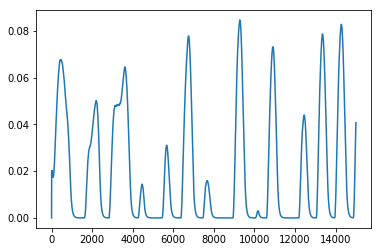

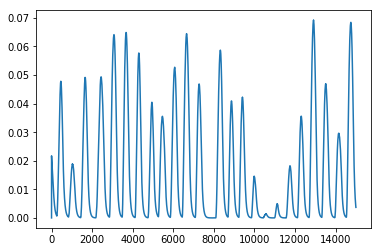

In [30]:

S= S.reshape((-1,nx,ny))

 
plt.plot(S[:,15,15])
plt.show()

plt.plot(S[:,15,45])

(30, 60)


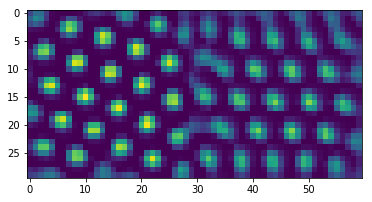

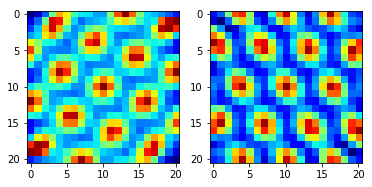

In [32]:
from htmresearch.support.gridcells.utils import cross_correlate


t = -1

img = S_[t].reshape((nx,ny))
print img.shape
plt.imshow(img)
plt.show()

w = 6
i, j = [15,15]
patch1 = img[i-w:i+w,j-w:j+w]

i, j = [15,45]
patch2 = img[i-w:i+w,j-w:j+w]

auto1 = cross_correlate(patch1,patch1)
auto2 = cross_correlate(patch2,patch2)


fig, ax = plt.subplots(1,2)

ax[0].imshow(auto1, cmap="jet")
ax[1].imshow(auto2, cmap="jet")



In [35]:
import numpy as np
import opencv as cv
import sys

if len(sys.argv) != 2:
    print('Input video name is missing')
    exit()

cv.namedWindow("tracking")
camera = cv.VideoCapture(sys.argv[1])
ok, image=camera.read()
if not ok:
    print('Failed to read video')
    exit()
bbox = cv.selectROI("tracking", image)
tracker = cv.TrackerMIL_create()
init_once = False

while camera.isOpened():
    ok, image=camera.read()
    if not ok:
        print 'no image to read'
        break

    if not init_once:
        ok = tracker.init(image, bbox)
        init_once = True

    ok, newbox = tracker.update(image)
    print ok, newbox

    if ok:
        p1 = (int(newbox[0]), int(newbox[1]))
        p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
        cv.rectangle(image, p1, p2, (200,0,0))

    cv.imshow("tracking", image)
    k = cv.waitKey(1) & 0xff
    if k == 27 : break # esc pressed

ImportError: No module named opencv

In [8]:
from htmresearch.support.cans.sort import *

#create instance of SORT
mot_tracker = Sort() 
